# Day 8-6: Prophet을 활용한 비즈니스 시계열 예측

---

## 📚 학습 목표

### Part 1: 기초 (Prophet 입문)
1. Prophet의 가법 모델 구조(Trend + Seasonality + Holidays)를 이해한다
2. Prophet이 요구하는 데이터 형식(ds, y)으로 데이터를 준비할 수 있다
3. holidays 파라미터를 사용하여 비즈니스 이벤트를 모델에 반영할 수 있다
4. 기본 Prophet 모델을 학습하고 미래를 예측할 수 있다
5. `plot_components()`를 사용하여 예측 결과를 분해하고 해석할 수 있다

### Part 2: 심화 (실무 활용)
1. changepoints를 활용하여 추세 변화점을 감지하고 설정할 수 있다
2. add_regressor를 사용하여 외부 변수(기온 등)를 모델에 주입할 수 있다
3. 시계열 교차검증(Rolling Window CV)으로 모델 성능을 평가할 수 있다
4. yhat_upper를 활용하여 비즈니스 의사결정(안전재고 전략)에 연결할 수 있다

---

## 🎯 왜 Prophet을 배우나요?

| 개념 | 실무 활용 | 예시 |
|------|----------|------|
| Prophet 가법 모델 | 비즈니스 요소별 분해 분석 | "이번 프로모션의 순수 매출 기여도는?" |
| holidays 파라미터 | 프로모션/이벤트 효과 정량화 | "블랙프라이데이 효과는 평균 대비 +80%" |
| changepoints | 비즈니스 구조 변화 감지 | "사이트 리뉴얼 이후 기울기 2배 증가" |
| add_regressor | 외부 요인 영향 분석 | "기온 1도 상승 시 의류 매출 -1.5%" |
| yhat_upper | 재고 최적화 의사결정 | "95% 신뢰구간 상한으로 안전재고 설정" |

**분석가 관점**: Prophet은 ARIMA와 달리 **비즈니스 언어(추세, 계절성, 휴일)**로 모델을 구성하고 결과를 분해하여 설명할 수 있어, 현업 관계자와의 의사결정 간극을 줄이는 데 매우 유리합니다.

---

## 환경 설정

In [1]:
!uv add prophet

Resolved 117 packages in 582ms                                       
⠙ Preparing packages... (0/6)                                                   
⠙ Preparing packages... (0/6)--------------     0 B/76.70 KiB           
⠙ Preparing packages... (0/6)-------------- 14.88 KiB/76.70 KiB         
⠙ Preparing packages... (0/6)-------------- 30.88 KiB/76.70 KiB         
⠙ Preparing packages... (0/6)----------- 46.88 KiB/76.70 KiB         
⠙ Preparing packages... (0/6)----------- 46.88 KiB/76.70 KiB         
importlib-resources  ------------------------------     0 B/36.58 KiB
⠙ Preparing packages... (0/6)----------- 46.88 KiB/76.70 KiB         
importlib-resources  ------------------------------ 14.87 KiB/36.58 KiB
⠙ Preparing packages... (0/6)----------- 46.88 KiB/76.70 KiB         
importlib-resources  ------------------------------ 14.87 KiB/36.58 KiB
⠙ Preparing packages... (0/6)----------- 46.88 KiB/76.70 KiB         
importlib-resources  ------------------------------ 14.87 KiB/36.5

In [ ]:
# 필수 라이브러리 설치 (최초 1회)
# !pip install prophet plotly pandas numpy

In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings('ignore')

# Prophet 로깅 비활성화 (깔끔한 출력)
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

print("환경 설정 완료!")

/teamspace/studios/this_studio/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


환경 설정 완료!


---

# Part 1: Prophet 기초

## 1.1 Prophet이란?

**Prophet**은 Meta(Facebook)에서 개발한 시계열 예측 라이브러리로, `가법 모델(Additive Model)` 을 사용합니다.

$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$

| 구성 요소 | 설명 | 비즈니스 해석 |
|----------|------|-------------|
| $g(t)$ | 추세 (Trend) | 기본 성장 패턴 |
| $s(t)$ | 계절성 (Seasonality) | 주간/연간 반복 패턴 |
| $h(t)$ | 휴일 효과 (Holidays)⭐ | 프로모션/이벤트 영향 |
| $\epsilon_t$ | 오차항 | 예측 불가능한 노이즈 |

### Prophet vs ARIMA 비교

| 항목 | ARIMA | Prophet |
|------|-------|--------|
| 모델 구조 | 자기회귀 + 이동평균 | 가법 모델 (추세+계절성+휴일) |
| 파라미터 | p, d, q (통계적) | 비즈니스 직관적 (changepoints, holidays) |
| 결측치 처리 | 민감함 | 자동 처리⭐ |
| 휴일/이벤트 | 별도 처리 필요 | 내장 지원 (holidays) |
| 결과 해석 | 통계적 (ACF, PACF) | 비즈니스적 (컴포넌트 분해) |

In [ ]:
##아리마는 원인 분석, prophet은 예측에 좀 더 충실

## 1.2 데이터 로드 및 탐색

온라인 쇼핑몰의 **의류 카테고리** 일별 매출 데이터를 분석합니다.

**비즈니스 시나리오**: 마케팅 팀에서 "다음 달 프로모션 때 매출이 얼마나 오를까?" 라는 질문에 답해야 합니다.

In [4]:
# 데이터 로드
sales_df = pd.read_csv('datasets/ecommerce_sales_data.csv', parse_dates=['ds'])
events_df = pd.read_csv('datasets/ecommerce_events.csv', parse_dates=['ds'])

print(f"매출 데이터: {len(sales_df):,}일")
print(f"이벤트 데이터: {len(events_df)}개")
print(f"\n데이터 기간: {sales_df['ds'].min().date()} ~ {sales_df['ds'].max().date()}")

매출 데이터: 730일
이벤트 데이터: 24개

데이터 기간: 2023-01-01 ~ 2024-12-30


In [5]:
# 매출 데이터 미리보기
sales_df.head(10)

,ds,y,temperature,discount_rate
0,2023-01-01,9710191.0,-0.8,0.263
1,2023-01-02,8869414.0,-2.3,0.479
2,2023-01-03,8725475.0,-0.4,0.235
3,2023-01-04,8643326.0,1.8,0.445
4,2023-01-05,8565198.0,-2.6,0.314
5,2023-01-06,7095718.0,-2.6,0.055
6,2023-01-07,7778362.0,1.9,0.065
7,2023-01-08,7580807.0,-0.1,0.083
8,2023-01-09,6278754.0,-3.2,0.021
9,2023-01-10,7500875.0,-0.6,0.001


In [6]:
# 기초 통계
print("[매출 기초 통계]")
print(f"평균 매출: {sales_df['y'].mean():,.0f}원")
print(f"중앙값: {sales_df['y'].median():,.0f}원")
print(f"표준편차: {sales_df['y'].std():,.0f}원")
print(f"최소: {sales_df['y'].min():,.0f}원")
print(f"최대: {sales_df['y'].max():,.0f}원")

[매출 기초 통계]
평균 매출: 7,261,352원
중앙값: 7,125,486원
표준편차: 2,259,107원
최소: 2,025,600원
최대: 16,070,702원


In [7]:
# Plotly로 시계열 시각화
fig = px.line(
    sales_df, x='ds', y='y',
    title='온라인 쇼핑몰 의류 매출 추이 (2년)',
    labels={'ds': '날짜', 'y': '매출 (원)'}
)
fig.update_layout(
    xaxis_title='날짜',
    yaxis_title='매출 (원)',
    hovermode='x unified'
)
fig.show()

### 💡 실무 예시: EDA에서 확인해야 할 것들

1. **추세**: 전반적으로 상승/하락 추세가 있는가?
2. **계절성**: 주기적으로 반복되는 패턴이 보이는가? (주간, 월간, 연간)
3. **이상치**: 갑자기 급증하거나 급감하는 시점이 있는가? → 이벤트/프로모션일 가능성
4. **변화점**: 특정 시점을 기점으로 패턴이 달라지는가?

In [9]:
# 이벤트 데이터 확인
print("[이벤트 종류]")
print(events_df['holiday'].value_counts())

[이벤트 종류]
holiday
new_product_launch    8
stock_shortage        6
system_maintenance    4
new_year_sale         2
summer_sale           2
black_friday          2
Name: count, dtype: int64


In [8]:
# 이벤트 상세 확인
events_df.sort_values('ds').head(15)

,holiday,ds,lower_window,upper_window
0,new_year_sale,2023-01-01,0,4
3,new_product_launch,2023-02-15,0,4
7,stock_shortage,2023-03-20,0,2
10,system_maintenance,2023-04-02,0,0
4,new_product_launch,2023-05-15,0,4
1,summer_sale,2023-07-01,0,6
8,stock_shortage,2023-08-10,0,2
5,new_product_launch,2023-08-15,0,4
11,system_maintenance,2023-10-01,0,0
6,new_product_launch,2023-11-15,0,4


---

## 1.3 Prophet 데이터 형식: ds, y

⭐⭐⭐Prophet은 **엄격하게 정해진 컬럼명**을 요구합니다:

| 컬럼명 | 타입 | 설명 |
|--------|------|------|
| `ds` | datetime | 날짜/시간 |
| `y` | numeric | 예측하려는 값 |

⚠️ **주의**: 컬럼명이 `date`, `sales` 등으로 되어 있으면 반드시 `ds`, `y`로 변환해야 합니다!

In [11]:
# Prophet 입력 데이터 준비 (이미 ds, y 형식임)
# 만약 컬럼명이 다르다면:
# df_prophet = df.rename(columns={'date': 'ds', 'sales': 'y'})

# 기본 Prophet 입력 데이터
df_prophet = sales_df[['ds', 'y']].copy()
print(f"Prophet 입력 데이터: {df_prophet.shape}")
df_prophet.head()

Prophet 입력 데이터: (730, 2)


,ds,y
0,2023-01-01,9710191.0
1,2023-01-02,8869414.0
2,2023-01-03,8725475.0
3,2023-01-04,8643326.0
4,2023-01-05,8565198.0


---

## 1.4 기본 Prophet 모델 학습

가장 간단한 형태의 Prophet 모델을 먼저 만들어 봅시다.

In [12]:
# 기본 Prophet 모델 생성
model_basic = Prophet(
    yearly_seasonality=True,   # 연간 계절성
    weekly_seasonality=True,   # 주간 계절성
    daily_seasonality=False    # 일간 계절성 (일별 데이터이므로 불필요)
)

# 모델 학습
model_basic.fit(df_prophet)
print("기본 모델 학습 완료!")

04:46:55 - cmdstanpy - INFO - Chain [1] start processing
04:46:55 - cmdstanpy - INFO - Chain [1] done processing


기본 모델 학습 완료!


In [13]:
# 미래 30일 예측을 위한 데이터프레임 생성
future_basic = model_basic.make_future_dataframe(periods=30)
print(f"전체 데이터프레임 크기: {len(future_basic)}")
print(f"예측 기간: {future_basic['ds'].max().date()}까지")

future_basic.tail()

전체 데이터프레임 크기: 760
예측 기간: 2025-01-29까지


,ds
755,2025-01-25
756,2025-01-26
757,2025-01-27
758,2025-01-28
759,2025-01-29


In [14]:
# 예측 수행
forecast_basic = model_basic.predict(future_basic)

# 예측 결과 주요 컬럼
print("[예측 결과 주요 컬럼]")
print("- ds: 날짜")
print("- yhat: 예측값 (점추정)")
print("- yhat_lower: 예측 하한 (95% 신뢰구간)")
print("- yhat_upper: 예측 상한 (95% 신뢰구간)")
print("- trend: 추세 성분")
print("- yearly: 연간 계절성")
print("- weekly: 주간 계절성")

[예측 결과 주요 컬럼]
- ds: 날짜
- yhat: 예측값 (점추정)
- yhat_lower: 예측 하한 (95% 신뢰구간)
- yhat_upper: 예측 상한 (95% 신뢰구간)
- trend: 추세 성분
- yearly: 연간 계절성
- weekly: 주간 계절성


In [15]:
# 미래 30일 예측 결과
forecast_basic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
750,2025-01-20,1.026666e+07,9.162854e+06,1.151015e+07
751,2025-01-21,1.075403e+07,9.548665e+06,1.198816e+07
752,2025-01-22,1.074585e+07,9.578942e+06,1.205122e+07
753,2025-01-23,1.064319e+07,9.470695e+06,1.179651e+07
754,2025-01-24,1.177378e+07,1.047022e+07,1.298669e+07
755,2025-01-25,1.237914e+07,1.120811e+07,1.350899e+07
756,2025-01-26,1.130497e+07,1.010393e+07,1.259687e+07
757,2025-01-27,1.031381e+07,9.207684e+06,1.159886e+07
758,2025-01-28,1.085647e+07,9.494518e+06,1.206681e+07
759,2025-01-29,1.089960e+07,9.660729e+06,1.208444e+07


### Prophet 내장 시각화

In [ ]:
pip install koreanize-matplotlib

Text(0.5, 0.98, 'Prophet 기본 모델 예측 결과')

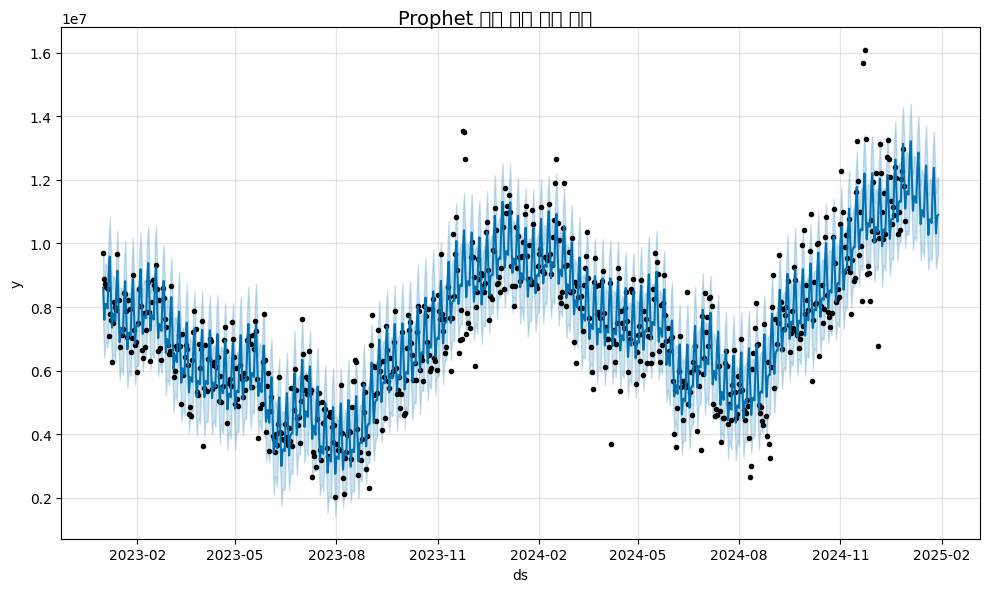

In [18]:
# Prophet 내장 예측 시각화
fig1 = model_basic.plot(forecast_basic)
fig1.suptitle('Prophet 기본 모델 예측 결과', fontsize=14)

In [19]:
import plotly.graph_objects as go

fig1 = go.Figure()
df = df_prophet

# 실제값 (학습 데이터)
fig1.add_trace(go.Scatter(
    x=df['ds'], 
    y=df['y'], 
    mode='markers', 
    name='실제값',
    marker=dict(color='black', size=3)
))

# 미래 예측 구간만 필터링 (학습 데이터 이후)
future_forecast = forecast_basic[forecast_basic['ds'] > df['ds'].max()]

# 예측값 (미래 구간만)
fig1.add_trace(go.Scatter(
    x=future_forecast['ds'], 
    y=future_forecast['yhat'], 
    mode='lines', 
    name='예측값',
    line=dict(color='blue')
))

# 95% 신뢰구간 (상한)
fig1.add_trace(go.Scatter(
    x=future_forecast['ds'], 
    y=future_forecast['yhat_upper'], 
    mode='lines', 
    name='95% 신뢰구간 상한',
    line=dict(width=0),
    showlegend=False
))

# 95% 신뢰구간 (하한 + 채우기)
fig1.add_trace(go.Scatter(
    x=future_forecast['ds'], 
    y=future_forecast['yhat_lower'], 
    mode='lines', 
    name='95% 신뢰구간',
    line=dict(width=0),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty'
))

fig1.update_layout(
    title='Prophet 기본 모델 예측 결과 (실제값 vs 예측값)', 
    xaxis_title='날짜', 
    yaxis_title='매출 (원)',
    hovermode='x unified'
)

fig1.show()

---

## 1.5 컴포넌트 분해: plot_components()

Prophet의 가장 큰 장점! 예측 결과를 **추세, 주간, 연간** 성분으로 분해하여 볼 수 있습니다.

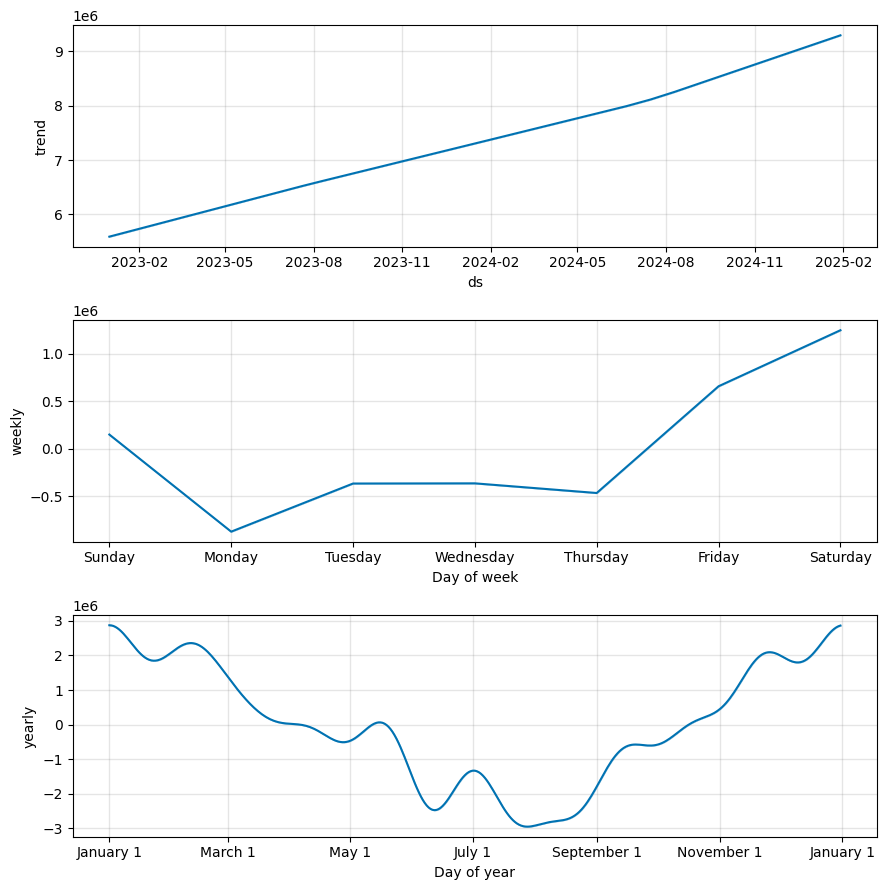

In [22]:
# 컴포넌트 분해 시각화
fig2 = model_basic.plot_components(forecast_basic)

### 💡 실무 예시: 컴포넌트 해석

1. **Trend (추세)**: 전반적인 성장/하락 패턴
   - 위 그래프에서 우상향하면 성장 추세, 우하향하면 하락 추세
   - 기울기가 변하는 지점 = changepoint (추세 변화점)

2. **Weekly (주간 계절성)**: 요일별 패턴
   - 금/토요일이 높으면 → 주말 쇼핑 패턴
   - 월요일이 낮으면 → 주초 피로 효과

3. **Yearly (연간 계절성)**: 월별/계절별 패턴
   - 겨울(12-2월)이 높으면 → 의류 특성 (아우터/패딩)
   - 여름(6-8월)이 낮으면 → 의류 비수기

### Plotly로 컴포넌트 시각화 (인터랙티브)

In [23]:
# 주간 계절성 시각화 (Plotly)
weekly_data = forecast_basic.groupby(forecast_basic['ds'].dt.dayofweek)['weekly'].mean().reset_index()
weekly_data['ds'] = weekly_data['ds'].map({0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'})

fig = px.bar(
    weekly_data, x='ds', y='weekly',
    title='주간 계절성 (요일별 매출 효과)',
    labels={'ds': '요일', 'weekly': '매출 효과 (원)'}
)
fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': ['월', '화', '수', '목', '금', '토', '일']})
fig.show()

---

## 1.6 Holidays (이벤트) 반영

실무에서는 **프로모션, 신규 출시, 재고 부족** 등 비정기 이벤트가 매출에 큰 영향을 미칩니다.

Prophet의 `holidays` 파라미터를 사용하면 이러한 이벤트를 모델에 직접 반영할 수 있습니다.

In [24]:
# 이벤트 데이터 확인
print("[이벤트 종류별 횟수]")
print(events_df['holiday'].value_counts())
print("\n[이벤트 윈도우 설정]")
events_df.groupby('holiday')[['lower_window', 'upper_window']].first()

[이벤트 종류별 횟수]
holiday
new_product_launch    8
stock_shortage        6
system_maintenance    4
new_year_sale         2
summer_sale           2
black_friday          2
Name: count, dtype: int64

[이벤트 윈도우 설정]


,lower_window,upper_window
holiday,,
black_friday,0,2
new_product_launch,0,4
new_year_sale,0,4
stock_shortage,0,2
summer_sale,0,6
system_maintenance,0,0


### 💡 실무 예시: lower_window, upper_window

이벤트의 영향이 딱 그날 하루에만 그치지 않는 경우가 많습니다.

| 파라미터 | 의미 | 예시 |
|----------|------|------|
| `lower_window` | 이벤트 **이전** 영향 기간 | 프로모션 사전 광고 효과 |
| `upper_window` | 이벤트 **이후** 지속 기간 | 세일 연장 효과 |

예: 여름세일 (7월 1일 시작, 7일간)
- `ds = 2023-07-01`
- `lower_window = 0` (사전 효과 없음)
- `upper_window = 6` (7일간 지속)

In [25]:
# holidays 파라미터로 이벤트 반영 모델
model_with_holidays = Prophet(
    holidays=events_df,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model_with_holidays.fit(df_prophet)
print("이벤트 반영 모델 학습 완료!")

04:57:30 - cmdstanpy - INFO - Chain [1] start processing
04:57:30 - cmdstanpy - INFO - Chain [1] done processing


이벤트 반영 모델 학습 완료!


In [26]:
# 예측
future_holidays = model_with_holidays.make_future_dataframe(periods=30)
forecast_holidays = model_with_holidays.predict(future_holidays)

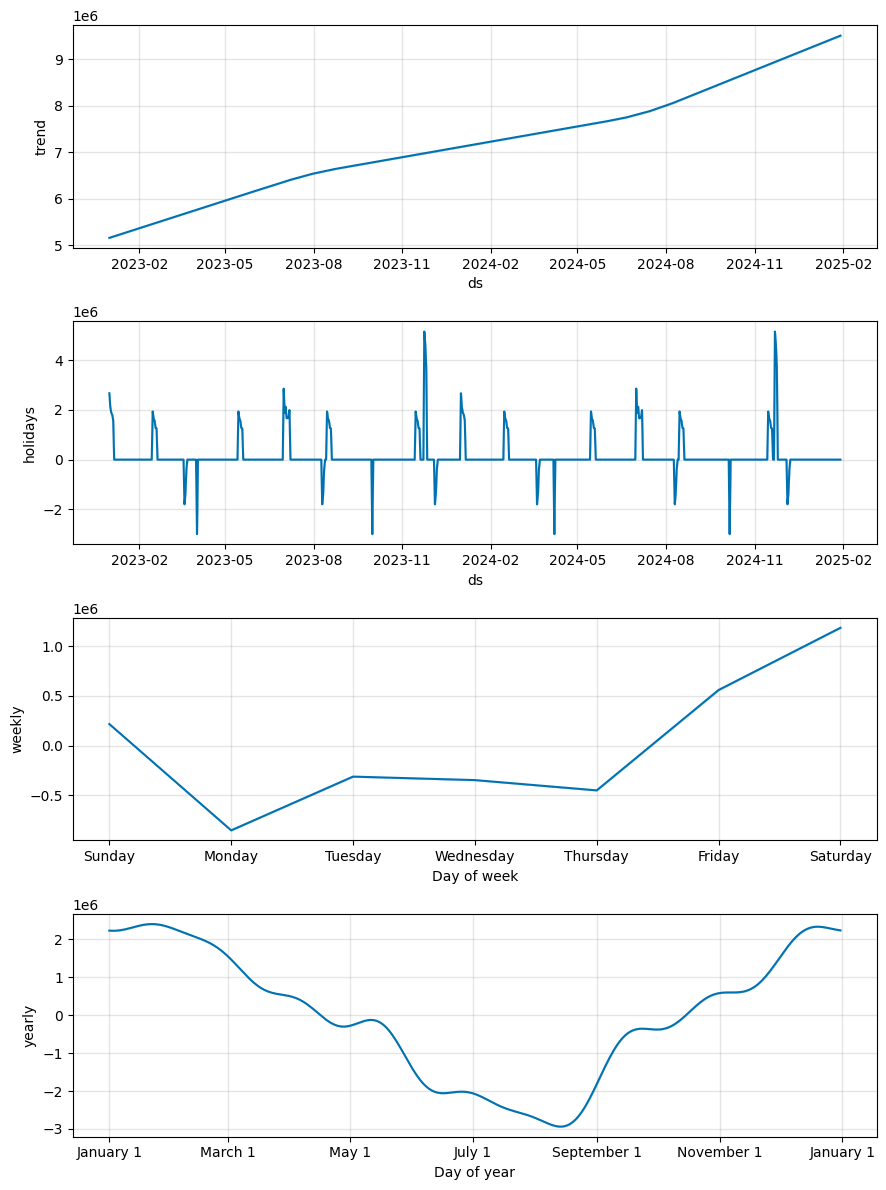

In [27]:
# 컴포넌트 분해 (holidays 포함)
fig3 = model_with_holidays.plot_components(forecast_holidays)

### 이벤트별 매출 기여도 확인

마케팅 팀의 질문: **"지난번 블랙프라이데이 이벤트가 실제로 매출에 얼마나 기여했나요?"**

In [34]:
pd.options.display.max_columns = None

In [ ]:
# 이벤트별 효과 컬럼 확인
event_cols = [col for col in forecast_holidays.columns if col in events_df['holiday'].unique()]
print("[이벤트 효과 컬럼]")
print(event_cols)

[이벤트 효과 컬럼]
['black_friday', 'new_product_launch', 'new_year_sale', 'stock_shortage', 'summer_sale', 'system_maintenance']


In [ ]:
# 이벤트별 평균 효과 계산
event_effects = {}
for event in events_df['holiday'].unique():
    if event in forecast_holidays.columns:
        # 이벤트 효과가 0이 아닌 날의 평균
        effect = forecast_holidays[forecast_holidays[event] != 0][event].mean() #0이 아닌 건 효과가 있다는 뜻
        event_effects[event] = effect

# 효과 크기순 정렬
effects_df = pd.DataFrame({
    '이벤트': event_effects.keys(),
    '평균 효과 (원)': event_effects.values()
}).sort_values('평균 효과 (원)', ascending=False)

effects_df

,이벤트,평균 효과 (원)
2,black_friday,4.488635e+06
0,new_year_sale,2.006139e+06
1,summer_sale,1.983173e+06
3,new_product_launch,1.535004e+06
4,stock_shortage,-1.179518e+06
5,system_maintenance,-2.994932e+06


In [30]:
# 이벤트 효과 시각화 (Plotly)
fig = px.bar(
    effects_df, x='이벤트', y='평균 효과 (원)',
    title='이벤트별 매출 기여도',
    color='평균 효과 (원)',
    color_continuous_scale=['red', 'white', 'green'],
    color_continuous_midpoint=0
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

### 💡 실무 예시: 마케팅 팀에 보고하기

```
[프로모션 효과 분석 보고]

1. 블랙프라이데이: 평균 +XXX만원 (가장 효과적)
2. 여름세일: 평균 +XXX만원
3. 신규상품 출시: 평균 +XXX만원

반면, 재고부족 기간은 평균 -XXX만원 손실 발생
→ 물류 안정화로 재고부족 방지 시 연간 XXX만원 추가 매출 기대
```

---

# Part 2: Prophet 심화

## 2.1 추세 변화점 (Changepoints)

비즈니스에서는 특정 시점을 기점으로 **"기본 체력(추세의 기울기)"**이 변하는 상황이 자주 발생합니다.

- 사이트 리뉴얼
- 신규 카테고리 론칭
- 경쟁사 진입/철수
- 코로나19 같은 외부 충격

In [35]:
# 자동 감지된 changepoints 확인
print("[자동 감지된 추세 변화점]")
print(f"개수: {len(model_with_holidays.changepoints)}")
print("\n변화점 목록 (상위 10개):")
for cp in model_with_holidays.changepoints[:10]:
    print(f"  - {cp.date()}")

[자동 감지된 추세 변화점]
개수: 25

변화점 목록 (상위 10개):
  - 2023-01-24
  - 2023-02-17
  - 2023-03-12
  - 2023-04-04
  - 2023-04-28
  - 2023-05-21
  - 2023-06-13
  - 2023-07-07
  - 2023-07-30
  - 2023-08-22


Text(0.5, 0.98, '추세 변화점 (빨간 점선)')

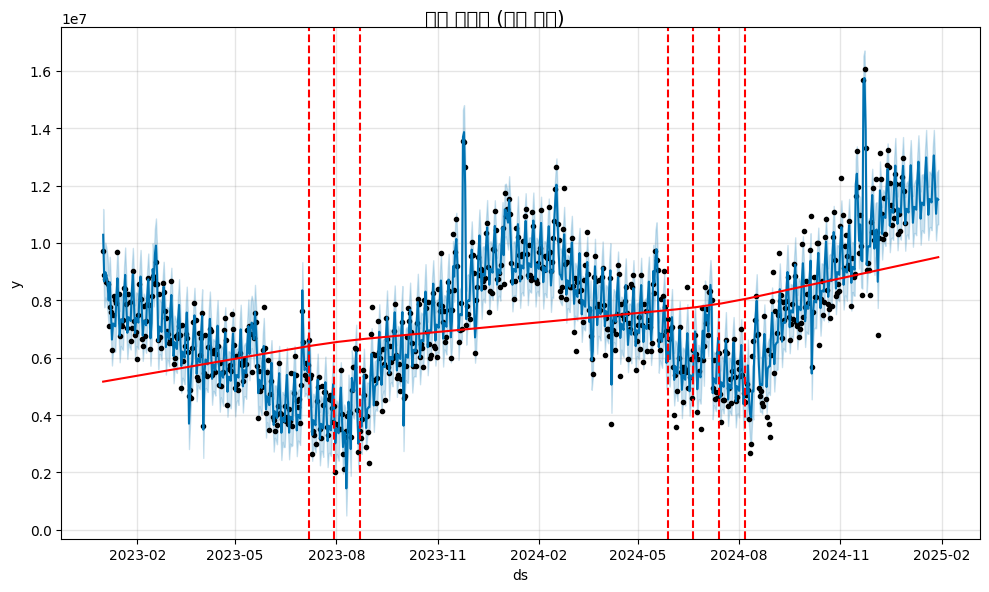

In [37]:
# 추세 변화점 시각화
from prophet.plot import add_changepoints_to_plot

fig = model_with_holidays.plot(forecast_holidays)
add_changepoints_to_plot(fig.gca(), model_with_holidays, forecast_holidays)
fig.suptitle('추세 변화점 (빨간 점선)', fontsize=14)

### 수동으로 Changepoint 설정

분석가가 알고 있는 비즈니스 이벤트를 직접 설정할 수 있습니다.

예: 2023년 6월 15일 사이트 리뉴얼

In [38]:
# 수동 changepoint 설정
model_manual_cp = Prophet(
    holidays=events_df,
    changepoints=['2023-06-15'],  # 사이트 리뉴얼 날짜
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model_manual_cp.fit(df_prophet)

future_manual = model_manual_cp.make_future_dataframe(periods=30)
forecast_manual = model_manual_cp.predict(future_manual)

print("수동 changepoint 모델 학습 완료!")

05:11:38 - cmdstanpy - INFO - Chain [1] start processing
05:11:38 - cmdstanpy - INFO - Chain [1] done processing


수동 changepoint 모델 학습 완료!


In [ ]:
# 변화점 전후 추세 비교⭐⭐  우리 분석에 많이 쓰일 수 있을 것 같음
changepoint = pd.Timestamp('2023-06-15')

before_cp = forecast_manual[forecast_manual['ds'] < changepoint]
after_cp = forecast_manual[forecast_manual['ds'] >= changepoint]

# 추세 기울기 계산 (일평균 변화량)
if len(before_cp) > 1:
    slope_before = (before_cp['trend'].iloc[-1] - before_cp['trend'].iloc[0]) / len(before_cp)
    slope_after = (after_cp['trend'].iloc[-1] - after_cp['trend'].iloc[0]) / len(after_cp)
    
    print(f"[추세 기울기 분석]")
    print(f"변화점 이전: 일 평균 +{slope_before:,.0f}원/일")
    print(f"변화점 이후: 일 평균 +{slope_after:,.0f}원/일")
    print(f"\n→ 리뉴얼 후 성장 속도 {slope_after/slope_before:.1f}배 증가!")

[추세 기울기 분석]
변화점 이전: 일 평균 +5,747원/일
변화점 이후: 일 평균 +4,544원/일

→ 리뉴얼 후 성장 속도 0.8배 증가!


### changepoint_prior_scale: 추세 유연성 조절

| 값 | 효과 | 사용 상황 |
|----|------|----------|
| 낮음 (0.001) | 추세가 거의 변하지 않음 | 안정적인 비즈니스 |
| 기본 (0.05) | 적당한 유연성 | 일반적인 상황 |
| 높음 (0.5) | 추세가 자주 변함 | 변동성 큰 비즈니스 |

In [40]:
# changepoint_prior_scale 비교
scales = [0.001, 0.05, 0.5]
forecasts = {}

for scale in scales:
    m = Prophet(
        holidays=events_df,
        changepoint_prior_scale=scale,
        yearly_seasonality=True,
        weekly_seasonality=True
    )
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods=30)
    forecasts[scale] = m.predict(future)

print("3개 모델 학습 완료!")

05:16:32 - cmdstanpy - INFO - Chain [1] start processing
05:16:32 - cmdstanpy - INFO - Chain [1] done processing
05:16:32 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:16:32 - cmdstanpy - INFO - Chain [1] start processing
05:16:33 - cmdstanpy - INFO - Chain [1] done processing
05:16:33 - cmdstanpy - INFO - Chain [1] start processing
05:16:34 - cmdstanpy - INFO - Chain [1] done processing
05:16:34 - cmdstanpy - INFO - Chain [1] start processing
05:16:34 - cmdstanpy - INFO - Chain [1] done processing


3개 모델 학습 완료!


In [41]:
# 추세 비교 시각화
fig = go.Figure()

for scale, forecast in forecasts.items():
    fig.add_trace(go.Scatter(
        x=forecast['ds'], y=forecast['trend'],
        name=f'scale={scale}',
        mode='lines'
    ))

fig.update_layout(
    title='changepoint_prior_scale에 따른 추세 비교',
    xaxis_title='날짜',
    yaxis_title='추세 (원)',
    hovermode='x unified'
)
fig.show()

---

## ⭐⭐⭐2.2 다변량 분석: add_regressor⭐⭐⭐

시계열 데이터 자체의 패턴(추세, 계절성) 외에 **외부 요인**이 매출에 영향을 줄 수 있습니다.

Prophet의 `add_regressor`를 사용하면 외부 변수를 모델에 주입할 수 있습니다.

$$y(t) = g(t) + s(t) + h(t) + \sum_{i=1}^{n} \beta_i X_i(t) + \epsilon_t$$

### ⭐⭐💡 실무 예시: 외부 변수 선택 기준💡⭐⭐

**핵심**: 예측하려는 미래 시점의 외부 변수 값을 **미리 알 수 있어야** 합니다!

| 변수 | 미래 값 확보 | 적합성 |
|------|-------------|--------|
| 기상청 기온 예보 | O (기상청 제공) | 적합 |
| 실시간 접속자 수 | X (또 다른 예측 필요) | 부적합 |
| 계획된 프로모션 할인율 | O (마케팅 계획) | 적합 |
| 경쟁사 가격 | △ (모니터링 필요) | 조건부 적합 |

In [43]:
# 외부 변수 포함 데이터 준비
df_with_regressor = sales_df[['ds', 'y', 'temperature', 'discount_rate']].copy()
print("[외부 변수]")
print(f"- 기온: {df_with_regressor['temperature'].min():.1f}°C ~ {df_with_regressor['temperature'].max():.1f}°C")
print(f"- 할인율: {df_with_regressor['discount_rate'].min():.1%} ~ {df_with_regressor['discount_rate'].max():.1%}")

[외부 변수]
- 기온: -7.3°C ~ 35.6°C
- 할인율: 0.0% ~ 49.3%


In [44]:
# 기온-매출 상관관계 확인
correlation = df_with_regressor['temperature'].corr(df_with_regressor['y'])
print(f"기온-매출 상관계수: {correlation:.3f}")
print("\n→ 음의 상관관계: 기온이 낮을수록 매출 증가 (의류 특성)")

기온-매출 상관계수: -0.679

→ 음의 상관관계: 기온이 낮을수록 매출 증가 (의류 특성)


In [45]:
# 기온-매출 산점도
fig = px.scatter(
    df_with_regressor, x='temperature', y='y',
    title='기온과 매출의 관계 (의류)',
    labels={'temperature': '기온 (°C)', 'y': '매출 (원)'},
    trendline='ols'
)
fig.show()

In [46]:
# add_regressor 모델 생성
model_regressor = Prophet(
    holidays=events_df,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# 외부 변수 추가 (fit 전에 호출!)
model_regressor.add_regressor('temperature')
model_regressor.add_regressor('discount_rate')

# 모델 학습
model_regressor.fit(df_with_regressor)
print("외부 변수 포함 모델 학습 완료!")

05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1] done processing


외부 변수 포함 모델 학습 완료!


In [47]:
# 미래 예측을 위한 데이터 준비
# ⚠️ 중요: 미래 기간의 외부 변수 값도 필요!

future_regressor = model_regressor.make_future_dataframe(periods=30)

# 미래 30일의 기온 예보 (예시: 1월이므로 추운 날씨)
# 실무에서는 기상청 API 등에서 실제 예보 데이터를 가져옴
np.random.seed(42)
future_temps = np.random.normal(-2, 3, 30)  # 1월 평균 기온
future_discounts = np.random.uniform(0, 0.1, 30)  # 평상시 할인율

# 기존 데이터의 외부 변수 + 미래 값 결합
all_temps = list(df_with_regressor['temperature']) + list(future_temps)
all_discounts = list(df_with_regressor['discount_rate']) + list(future_discounts)

future_regressor['temperature'] = all_temps
future_regressor['discount_rate'] = all_discounts

print("미래 외부 변수 설정 완료!")
future_regressor.tail()

미래 외부 변수 설정 완료!


,ds,temperature,discount_rate
755,2025-01-25,-1.667232,0.035675
756,2025-01-26,-5.452981,0.028093
757,2025-01-27,-0.872906,0.054270
758,2025-01-28,-3.801916,0.014092
759,2025-01-29,-2.875081,0.080220


In [48]:
# 예측
forecast_regressor = model_regressor.predict(future_regressor)

In [49]:
# 외부 변수 효과 확인
print("[외부 변수 효과]")
print(f"기온 효과 범위: {forecast_regressor['extra_regressors_additive'].min():,.0f} ~ {forecast_regressor['extra_regressors_additive'].max():,.0f}원")

# 개별 변수 효과 확인
if 'temperature' in forecast_regressor.columns:
    temp_effect = forecast_regressor['temperature'].mean()
    print(f"\n기온 변수 평균 효과: {temp_effect:,.0f}원")

[외부 변수 효과]
기온 효과 범위: -2,564,676 ~ 2,495,785원

기온 변수 평균 효과: 70,279원


### 시나리오 분석: 할인율 변경 시 매출 예측

마케팅 팀 질문: **"다음 주에 30% 할인 프로모션을 하면 매출이 얼마나 오를까?"**

In [50]:
# 시나리오 A: 할인 없음 (0%)
future_scenario_a = future_regressor.copy()
future_scenario_a.loc[future_scenario_a.index[-30:], 'discount_rate'] = 0.0
forecast_a = model_regressor.predict(future_scenario_a)

In [51]:

# 시나리오 B: 30% 할인
future_scenario_b = future_regressor.copy()
future_scenario_b.loc[future_scenario_b.index[-30:], 'discount_rate'] = 0.3
forecast_b = model_regressor.predict(future_scenario_b)

# 비교
sales_a = forecast_a.tail(30)['yhat'].sum()
sales_b = forecast_b.tail(30)['yhat'].sum()

print("[시나리오 분석: 향후 30일 예상 매출]")
print(f"시나리오 A (할인 없음): {sales_a:,.0f}원")
print(f"시나리오 B (30% 할인): {sales_b:,.0f}원")
print(f"\n예상 매출 증가: {sales_b - sales_a:,.0f}원 ({(sales_b/sales_a - 1)*100:.1f}%)")

[시나리오 분석: 향후 30일 예상 매출]
시나리오 A (할인 없음): 354,263,643원
시나리오 B (30% 할인): 367,058,273원

예상 매출 증가: 12,794,629원 (3.6%)


---

## 2.3 시계열 교차검증 (Cross-Validation)

시계열 데이터는 일반적인 Random Split을 사용하면 안 됩니다!

Prophet은 **Rolling Window** 방식의 교차검증을 제공합니다.

### Rolling Window CV 개념

```
Fold 1: [===Train===][Test]
Fold 2:    [===Train===][Test]
Fold 3:       [===Train===][Test]
Fold 4:          [===Train===][Test]
```

| 파라미터 | 의미 | 예시 |
|----------|------|------|
| `initial` | 첫 학습 기간 | '365 days' (1년) |
| `period` | Fold 간 간격 | '30 days' (1개월) |
| `horizon` | 예측 기간 | '30 days' (1개월) |

In [52]:
# 시계열 교차검증 수행
# 주의: 시간이 다소 걸릴 수 있습니다
df_cv = cross_validation(
    model_with_holidays,
    initial='365 days',   # 첫 학습 기간: 1년
    period='30 days',     # Fold 간격: 1개월
    horizon='30 days'     # 예측 기간: 1개월
)

print(f"교차검증 결과: {len(df_cv):,}개 예측")
df_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]05:26:34 - cmdstanpy - INFO - Chain [1] start processing
05:26:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.76it/s]05:26:34 - cmdstanpy - INFO - Chain [1] start processing
05:26:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.45it/s]05:26:34 - cmdstanpy - INFO - Chain [1] start processing
05:26:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.34it/s]05:26:34 - cmdstanpy - INFO - Chain [1] start processing
05:26:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.66it/s]05:26:34 - cmdstanpy - INFO - Chain [1] start processing
05:26:34 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.91it/s]05:26:35 - cmdstanpy - INFO - Chain [1] start processing
05:26:

교차검증 결과: 360개 예측


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-01-06,1.064155e+07,9.869863e+06,1.141900e+07,10997152.0,2024-01-05
1,2024-01-07,9.840702e+06,9.082585e+06,1.059544e+07,9294827.0,2024-01-05
2,2024-01-08,8.837063e+06,8.036427e+06,9.637015e+06,8669604.0,2024-01-05
3,2024-01-09,9.333170e+06,8.566922e+06,1.007520e+07,8029993.0,2024-01-05
4,2024-01-10,9.447601e+06,8.646873e+06,1.029147e+07,8676664.0,2024-01-05


In [53]:
# 성능 지표 계산
df_performance = performance_metrics(df_cv)
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.381198e+12,1.175244e+06,938756.367519,0.132486,0.094468,0.125155,0.638889
1,4 days,1.325690e+12,1.151386e+06,924717.550524,0.128073,0.094468,0.123000,0.611111
2,5 days,1.269523e+12,1.126731e+06,889982.116107,0.117516,0.094468,0.115389,0.611111
3,6 days,9.937532e+11,9.968717e+05,789744.546049,0.098799,0.076119,0.099334,0.611111
4,7 days,1.030275e+12,1.015025e+06,836126.221651,0.107299,0.109804,0.107208,0.555556
5,8 days,8.682551e+11,9.318021e+05,824281.040846,0.111488,0.109804,0.109489,0.555556
6,9 days,9.251077e+11,9.618252e+05,850522.710674,0.127110,0.112715,0.120944,0.555556
7,10 days,6.977654e+11,8.353235e+05,720528.247016,0.112233,0.080724,0.106186,0.666667
8,11 days,7.432490e+11,8.621189e+05,725341.029008,0.109672,0.077833,0.105230,0.638889
9,12 days,7.457141e+11,8.635474e+05,683062.740005,0.092805,0.076181,0.093460,0.666667


In [54]:
# 주요 지표 요약
print("[모델 성능 요약]")
print(f"MAPE (평균 절대 백분율 오차): {df_performance['mape'].mean()*100:.2f}%")
print(f"RMSE (평균 제곱근 오차): {df_performance['rmse'].mean():,.0f}원")
print(f"MAE (평균 절대 오차): {df_performance['mae'].mean():,.0f}원")

[모델 성능 요약]
MAPE (평균 절대 백분율 오차): 9.87%
RMSE (평균 제곱근 오차): 886,599원
MAE (평균 절대 오차): 713,938원


### 💡 실무 예시: MAPE vs RMSE

| 지표 | 특징 | 사용 상황 |
|------|------|----------|
| **MAPE** | 상대적 오차 (%) | 규모가 다른 데이터 비교 (매장별 성과) |
| **RMSE** | 절대적 오차 (원) | 큰 오차에 민감 (재고 관리) |

In [56]:
# 예측 기간별 MAPE 시각화
fig = px.line(
    df_performance, x='horizon', y='mape',
    title='예측 기간별 MAPE',
    labels={'horizon': '예측 기간', 'mape': 'MAPE'}
)
fig.update_yaxes(tickformat='.1%')
fig.show()

---

## 2.4 비즈니스 의사결정: yhat_upper 활용

재고 관리 팀의 고민: **"물건이 남는 것도 문제지만, 품절(Out-of-stock)이 제일 두렵다."**

Prophet은 예측값(yhat)과 함께 **불확실성 구간**을 제공합니다:
- `yhat_lower`: 95% 신뢰구간 하한
- `yhat_upper`: 95% 신뢰구간 상한

In [57]:
# 미래 30일 예측 결과
future_30 = forecast_holidays.tail(30)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
future_30['날짜'] = future_30['ds'].dt.strftime('%Y-%m-%d')
future_30

,ds,yhat,yhat_lower,yhat_upper,날짜
730,2024-12-31,1.118973e+07,1.026941e+07,1.209063e+07,2024-12-31
731,2025-01-01,1.115782e+07,1.029147e+07,1.214773e+07,2025-01-01
732,2025-01-02,1.105973e+07,1.014456e+07,1.199750e+07,2025-01-02
733,2025-01-03,1.207558e+07,1.114442e+07,1.296503e+07,2025-01-03
734,2025-01-04,1.271064e+07,1.181945e+07,1.358633e+07,2025-01-04
735,2025-01-05,1.175523e+07,1.090125e+07,1.272200e+07,2025-01-05
736,2025-01-06,1.070124e+07,9.865073e+06,1.163306e+07,2025-01-06
737,2025-01-07,1.125752e+07,1.033994e+07,1.206236e+07,2025-01-07
738,2025-01-08,1.124050e+07,1.034332e+07,1.219846e+07,2025-01-08
739,2025-01-09,1.115680e+07,1.026632e+07,1.205966e+07,2025-01-09


In [58]:
# 예측 구간 시각화
fig = go.Figure()

# 신뢰구간 (영역)
fig.add_trace(go.Scatter(
    x=list(future_30['ds']) + list(future_30['ds'][::-1]),
    y=list(future_30['yhat_upper']) + list(future_30['yhat_lower'][::-1]),
    fill='toself',
    fillcolor='rgba(0, 100, 200, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% 신뢰구간'
))

# 예측값
fig.add_trace(go.Scatter(
    x=future_30['ds'], y=future_30['yhat'],
    mode='lines+markers',
    name='예측값 (yhat)',
    line=dict(color='blue', width=2)
))

# 안전재고 기준선 (yhat_upper)
fig.add_trace(go.Scatter(
    x=future_30['ds'], y=future_30['yhat_upper'],
    mode='lines',
    name='안전재고 기준 (yhat_upper)',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title='향후 30일 매출 예측 및 안전재고 기준',
    xaxis_title='날짜',
    yaxis_title='매출 (원)',
    hovermode='x unified'
)
fig.show()

In [59]:
# 안전재고 전략 리포트
total_yhat = future_30['yhat'].sum()
total_upper = future_30['yhat_upper'].sum()
safety_buffer = total_upper - total_yhat

print("="*60)
print("[안전재고 전략 리포트: 향후 30일]")
print("="*60)
print(f"\n예상 매출 (점추정): {total_yhat:,.0f}원")
print(f"안전재고 기준 (상한): {total_upper:,.0f}원")
print(f"안전 버퍼: +{safety_buffer:,.0f}원 (+{safety_buffer/total_yhat*100:.1f}%)")
print(f"\n권장 재고 수준: {total_upper:,.0f}원 상당의 상품 확보")
print(f"→ 품절 리스크 5% 이하로 유지")
print("="*60)

[안전재고 전략 리포트: 향후 30일]

예상 매출 (점추정): 350,578,137원
안전재고 기준 (상한): 378,595,332원
안전 버퍼: +28,017,195원 (+8.0%)

권장 재고 수준: 378,595,332원 상당의 상품 확보
→ 품절 리스크 5% 이하로 유지


---

## 📊 학습 정리

### Part 1: 기초 핵심 요약

| 개념 | 설명 | Prophet 파라미터/함수 |
|------|------|----------------------|
| 가법 모델 | y = 추세 + 계절성 + 휴일 + 오차 | Prophet() 기본 구조 |
| 데이터 형식 | 반드시 ds, y 컬럼명 | `rename(columns={'date': 'ds'})` |
| 기본 학습 | 모델 생성 → fit → predict | `Prophet().fit(df).predict(future)` |
| 컴포넌트 분해 | 추세/계절성/휴일 효과 분리 | `model.plot_components()` |
| 이벤트 반영 | 프로모션, 재고부족 등 | `holidays=events_df` |

### Part 2: 심화 핵심 요약

| 개념 | 설명 | Prophet 파라미터/함수 |
|------|------|----------------------|
| 추세 변화점 | 비즈니스 구조 변화 반영 | `changepoints=['2023-06-15']` |
| 추세 유연성 | MA 대체, 변동 민감도 | `changepoint_prior_scale=0.05` |
| 외부 변수 | 기온, 할인율 등 반영 | `model.add_regressor('temp')` |
| 교차검증 | Rolling Window 방식 | `cross_validation(initial, period, horizon)` |
| 안전재고 | 품절 방지 전략 | `yhat_upper` (95% 상한) |

### 💡 실무 팁

1. **데이터 준비**: ds, y 컬럼명 필수! 다른 이름이면 rename 필수
2. **이벤트 정의**: lower_window/upper_window로 효과 지속 기간 설정
3. **외부 변수**: 미래 값을 알 수 있는 변수만 add_regressor에 추가
4. **changepoint**: 수동 설정 시 비즈니스 이벤트 날짜 사용
5. **성능 지표**: MAPE는 상대 비교용, RMSE는 절대 오차용
6. **재고 전략**: yhat_upper로 품절 방지, yhat_lower로 과잉재고 방지
7. **보고서**: plot_components로 비즈니스 언어로 설명 가능

---

# 🎯 실습 퀴즈

## Q1. Prophet 데이터 형식 ⭐

다음 데이터프레임을 Prophet 입력 형식으로 변환하세요.

```python
raw_df = pd.DataFrame({
    'order_date': pd.date_range('2024-01-01', periods=10),
    'revenue': [100, 120, 90, 150, 200, 180, 160, 140, 130, 170]
})
```

In [ ]:
# Q1. 여기에 코드를 작성하세요
raw_df = pd.DataFrame({
    'order_date': pd.date_range('2024-01-01', periods=10),
    'revenue': [100, 120, 90, 150, 200, 180, 160, 140, 130, 170]
})

# Prophet 형식으로 변환
prophet_df = ...

## Q2. 기본 모델 학습 및 예측 ⭐

아래 조건으로 Prophet 모델을 학습하고 7일 후까지 예측하세요.

- 연간 계절성: True
- 주간 계절성: True
- 일간 계절성: False

In [ ]:
# Q2. 여기에 코드를 작성하세요
# 데이터 준비
train_df = sales_df[['ds', 'y']].copy()

# 모델 생성 및 학습
model_q2 = ...

# 미래 7일 예측
future_q2 = ...
forecast_q2 = ...

## Q3. 이벤트 효과 분석 ⭐⭐

블랙프라이데이의 **평균 매출 기여도**를 계산하고 출력하세요.

In [ ]:
# Q3. 여기에 코드를 작성하세요
# forecast_holidays 데이터프레임 사용

# 블랙프라이데이 효과 계산
bf_effect = ...

## Q4. 이벤트 윈도우 설정 ⭐⭐

다음 조건의 이벤트 데이터프레임을 생성하세요.

- 이벤트명: 'spring_promo'
- 날짜: 2024-03-01, 2024-03-15
- 사전 효과: 2일
- 사후 효과: 5일

In [ ]:
# Q4. 여기에 코드를 작성하세요
spring_promo = pd.DataFrame({
    'holiday': ...,
    'ds': ...,
    'lower_window': ...,
    'upper_window': ...
})

## Q5. 주간 계절성 해석 ⭐⭐

모델의 주간 계절성에서 **가장 매출이 높은 요일**과 **가장 낮은 요일**을 찾으세요.

In [ ]:
# Q5. 여기에 코드를 작성하세요
# forecast_holidays 데이터프레임 사용

# 요일별 계절성 효과 계산
weekly_effect = ...

# 최고/최저 요일
best_day = ...
worst_day = ...

## Q6. Changepoint 설정 ⭐⭐⭐

2023년 10월 1일에 대규모 마케팅 캠페인이 시작되었다고 가정합니다.
이 날짜를 changepoint로 설정한 모델을 만들고 학습하세요.

In [ ]:
# Q6. 여기에 코드를 작성하세요
model_q6 = Prophet(
    ...
)

# 학습
...

## Q7. 외부 변수 추가 ⭐⭐⭐

기온(temperature)을 외부 변수로 추가한 모델을 만들고 학습하세요.

In [ ]:
# Q7. 여기에 코드를 작성하세요
# 데이터 준비
train_with_temp = sales_df[['ds', 'y', 'temperature']].copy()

# 모델 생성 및 외부 변수 추가
model_q7 = ...

# 학습
...

## Q8. 시나리오 분석 ⭐⭐⭐⭐

model_regressor를 사용하여 두 가지 시나리오를 비교하세요.

- 시나리오 A: 향후 7일 평균 기온 0°C
- 시나리오 B: 향후 7일 평균 기온 20°C

두 시나리오의 7일 총 매출 차이를 계산하세요.

In [ ]:
# Q8. 여기에 코드를 작성하세요
# 시나리오 A (기온 0°C)
scenario_a = ...

# 시나리오 B (기온 20°C)
scenario_b = ...

# 매출 차이 계산
sales_diff = ...

## Q9. 교차검증 수행 ⭐⭐⭐⭐

model_with_holidays에 대해 다음 조건으로 교차검증을 수행하고 평균 MAPE를 계산하세요.

- initial: 180일
- period: 14일
- horizon: 14일

In [ ]:
# Q9. 여기에 코드를 작성하세요
df_cv_q9 = cross_validation(
    ...
)

# 성능 지표 계산
df_perf_q9 = ...

# 평균 MAPE
avg_mape = ...

## Q10. 비즈니스 리포트 작성 ⭐⭐⭐⭐⭐

마케팅 팀에 제출할 **향후 7일 예측 리포트**를 작성하세요.

포함 내용:
1. 총 예상 매출 (yhat 합계)
2. 안전재고 기준 (yhat_upper 합계)
3. 최고 매출 예상일과 금액
4. 품절 방지를 위한 권장 사항

In [ ]:
# Q10. 여기에 코드를 작성하세요
# 향후 7일 예측 데이터 추출
next_7_days = forecast_holidays.tail(7)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

# 리포트 작성
print("="*60)
print("[마케팅 팀 제출용: 향후 7일 매출 예측 리포트]")
print("="*60)

# 1. 총 예상 매출
total_yhat = ...

# 2. 안전재고 기준
total_upper = ...

# 3. 최고 매출 예상일
best_day = ...

# 4. 권장 사항
...